# Model Comparison Lab

In this lab we will compare the performance of all the models we have learned about so far, using the Titanic dataset.


## 1. Prepare the data

The [titanic dataset](https://www.kaggle.com/c/titanic/data) is one we've talked about a lot. Load in the train data from the assets folder.

1. Load the data into a pandas dataframe
- Encode the categorical features properly
- Separate features from target into X and y

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

titanic = pd.read_csv('assets/train.csv')
titanic.dropna(inplace=True)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [2]:
titanic['Sex']  = [1 if person == 'female' else 0 for person in titanic.Sex ]

y = titanic.Survived
X = titanic[['Pclass', 'Sex', 'Age', 'Fare']]

## 2. Useful preparation

Since we will compare several models, let's write a couple of helper functions.

1. Separate X and y between a train and test set, using 30% test set, random state = 42
    - make sure that the data is shuffled and stratified
2. Define a function called `evaluate_model`, that trains the model on the train set, tests it on the test, calculates the evaluative measures below.
  - accuracy score
  - confusion matrix
  - classification report
3. Initialize a global dictionary to store the various models for later retrieval (your dictionary will likely contain the estimator and best score)

In [69]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

all_models = []

def evaluate_model(model,name):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    score = accuracy_score(y_test, predictions)
    matrix = confusion_matrix(y_test, predictions)
    class_report = classification_report(y_test, predictions)
    
    print matrix
    print class_report
    print score
    entry = {}
    entry['model'] = name
    entry['score'] = score
    all_models.append(entry)


## 3.a KNN

Let's start with `KNeighborsClassifier`.

1. Initialize a KNN model
- Evaluate its performance with the function you previously defined
- Find the optimal value of parameter K using grid search
    - Be careful on how you perform the cross validation in the grid search

In [70]:
from sklearn.neighbors import KNeighborsClassifier

evaluate_model(KNeighborsClassifier(),'KNN_baseline')

[[ 3 15]
 [ 3 34]]
             precision    recall  f1-score   support

          0       0.50      0.17      0.25        18
          1       0.69      0.92      0.79        37

avg / total       0.63      0.67      0.61        55

0.672727272727


In [101]:
from sklearn.model_selection import GridSearchCV

params = {'n_neighbors': range(2,60)}

gridsearch_knn = GridSearchCV(KNeighborsClassifier(),
                     params, n_jobs=-1,
                     cv=5)
gridsearch_knn.fit(X_train, y_train)

evaluate_model(gridsearch_knn.best_estimator_,'KNN_gs')

[[ 3 15]
 [ 4 33]]
             precision    recall  f1-score   support

          0       0.43      0.17      0.24        18
          1       0.69      0.89      0.78        37

avg / total       0.60      0.65      0.60        55

0.654545454545


## 3.b Bagging + KNN

Now that we have found the optimal K, let's wrap `KNeighborsClassifier` in a BaggingClassifier and see if the score improves.

1. Wrap the KNN model in a Bagging Classifier
- Evaluate performance
- Do a grid search only on the bagging classifier parameters

In [6]:
from sklearn.ensemble import BaggingClassifier

In [72]:
evaluate_model(BaggingClassifier(KNeighborsClassifier()),'KNN_bag')

[[ 6 12]
 [ 7 30]]
             precision    recall  f1-score   support

          0       0.46      0.33      0.39        18
          1       0.71      0.81      0.76        37

avg / total       0.63      0.65      0.64        55

0.654545454545


In [105]:
def bag_classifier(model,name):
    bagging_params = {'n_estimators': [10, 20],
                      'max_samples': [0.7, 1.0],
                      'max_features': [0.7, 1.0],
                      'bootstrap_features': [True, False]}
    bag = GridSearchCV(BaggingClassifier(model),
                                bagging_params, n_jobs=-1,
                                cv=5)

    bag.fit(X_train, y_train)
#     print 'test', bag.score(X_test,y_test)
#     print bag.best_params_
#     print bag.best_score_

    entry = {}
    entry['model'] = name
    entry['score'] = bag.best_score_
    
    all_models.append(entry)
#     evaluate_model(bag.best_estimator_,name)
#     return bag.best_estimator

In [106]:
bag_classifier(KNeighborsClassifier(),'KNN_bag_gs')

## 4. Logistic Regression

Let's see if logistic regression performs better.

1. Initialize LR and test on Train/Test set
- Find optimal parameters with Grid Search
- See if Bagging improves the score

In [76]:
from sklearn.linear_model import LogisticRegression

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
evaluate_model(LogisticRegression(),'LR_baseline')

[[14  4]
 [ 9 28]]
             precision    recall  f1-score   support

          0       0.61      0.78      0.68        18
          1       0.88      0.76      0.81        37

avg / total       0.79      0.76      0.77        55

0.763636363636


In [102]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],'penalty':['l1','l2'] }
gridsearch_LR = GridSearchCV(LogisticRegression(), param_grid)
gridsearch_LR.fit(X_train, y_train)

evaluate_model(gridsearch_LR.best_estimator_,'LR_gs')

[[12  6]
 [ 9 28]]
             precision    recall  f1-score   support

          0       0.57      0.67      0.62        18
          1       0.82      0.76      0.79        37

avg / total       0.74      0.73      0.73        55

0.727272727273


In [78]:
evaluate_model(BaggingClassifier(LogisticRegression()),'LR_bag')

[[13  5]
 [ 8 29]]
             precision    recall  f1-score   support

          0       0.62      0.72      0.67        18
          1       0.85      0.78      0.82        37

avg / total       0.78      0.76      0.77        55

0.763636363636


In [79]:
bag_classifier(LogisticRegression(C=1,penalty='l2'),'LR_bag_gs')

[[ 9  9]
 [ 4 33]]
             precision    recall  f1-score   support

          0       0.69      0.50      0.58        18
          1       0.79      0.89      0.84        37

avg / total       0.76      0.76      0.75        55

0.763636363636


## 5. Decision Trees

Let's see if Decision Trees perform better.

1. Initialize DT and test on Train/Test set
- Find optimal parameters with Grid Search
- See if Bagging improves the score

In [80]:
from sklearn.tree import DecisionTreeClassifier

evaluate_model(DecisionTreeClassifier(),'DT_baseline')

[[15  3]
 [ 5 32]]
             precision    recall  f1-score   support

          0       0.75      0.83      0.79        18
          1       0.91      0.86      0.89        37

avg / total       0.86      0.85      0.86        55

0.854545454545


In [81]:
params = {'criterion': ['gini', 'entropy'],
          'splitter': ['best', 'random'],
          'max_depth': [None, 5, 10],
          'min_samples_split': [2, 5],
          'min_samples_leaf': [1, 2, 3]}

gridsearch_dt = GridSearchCV(DecisionTreeClassifier(),
                    params, n_jobs=-1,
                    cv=5)

gridsearch_dt.fit(X, y)
evaluate_model(gridsearch_dt.best_estimator_,'DT_gs')

[[13  5]
 [ 6 31]]
             precision    recall  f1-score   support

          0       0.68      0.72      0.70        18
          1       0.86      0.84      0.85        37

avg / total       0.80      0.80      0.80        55

0.8


In [85]:
evaluate_model(BaggingClassifier(gridsearch_dt.best_estimator_),'DT_bag')

[[15  3]
 [ 5 32]]
             precision    recall  f1-score   support

          0       0.75      0.83      0.79        18
          1       0.91      0.86      0.89        37

avg / total       0.86      0.85      0.86        55

0.854545454545


In [86]:
bag_classifier(gridsearch_dt.best_estimator_,'DT_bag_gs')

[[13  5]
 [ 8 29]]
             precision    recall  f1-score   support

          0       0.62      0.72      0.67        18
          1       0.85      0.78      0.82        37

avg / total       0.78      0.76      0.77        55

0.763636363636


## 6. Random Forest & Extra Trees

Let's see if Random Forest and Extra Trees perform better.

1. Initialize RF and ET and test on Train/Test set
- Find optimal parameters with Grid Search


In [87]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

evaluate_model(RandomForestClassifier(),'RF_baseline')
evaluate_model(ExtraTreesClassifier(),'ET_baseline')

[[13  5]
 [ 8 29]]
             precision    recall  f1-score   support

          0       0.62      0.72      0.67        18
          1       0.85      0.78      0.82        37

avg / total       0.78      0.76      0.77        55

0.763636363636
[[14  4]
 [ 5 32]]
             precision    recall  f1-score   support

          0       0.74      0.78      0.76        18
          1       0.89      0.86      0.88        37

avg / total       0.84      0.84      0.84        55

0.836363636364


In [60]:
params = {'n_estimators':[3, 5, 10, 50],
          'criterion': ['gini', 'entropy'],
          'max_depth': [None, 3, 5],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}


gridsearch_RF = GridSearchCV(RandomForestClassifier(n_jobs=-1),
                    params, n_jobs=-1,
                    cv=5)

gridsearch_ET = GridSearchCV(ExtraTreesClassifier(n_jobs=-1),
                    params, n_jobs=-1,
                    cv=5)


gridsearch_RF.fit(X_train, y_train)
gridsearch_ET.fit(X_train, y_train)


In [58]:
gridsearch_RF.best_params_

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'min_samples_split': 2,
 'n_estimators': 50}

In [59]:
gridsearch_ET.best_params_

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'min_samples_split': 2,
 'n_estimators': 3}

In [88]:

evaluate_model(RandomForestClassifier(class_weight=None,criterion='gini',max_depth= 3,min_samples_split= 2,n_estimators=50),'RF_gs')
evaluate_model(ExtraTreesClassifier(class_weight=None,criterion='gini',max_depth= 3,min_samples_split= 2,n_estimators=3),'ET_gs')


[[11  7]
 [ 6 31]]
             precision    recall  f1-score   support

          0       0.65      0.61      0.63        18
          1       0.82      0.84      0.83        37

avg / total       0.76      0.76      0.76        55

0.763636363636
[[17  1]
 [11 26]]
             precision    recall  f1-score   support

          0       0.61      0.94      0.74        18
          1       0.96      0.70      0.81        37

avg / total       0.85      0.78      0.79        55

0.781818181818


## 8. Model comparison

Let's compare the scores of the various models.

1. Do a bar chart of the scores of the best models. Who's the winner on the train/test split?
- Re-test all the models using a 3 fold stratified shuffled cross validation
- Do a bar chart with errorbars of the cross validation average scores. is the winner the same?


In [91]:
all_models

[{'model': 'KNN_baseline', 'score': 0.67272727272727273},
 {'model': 'KNN_gs', 'score': 0.65454545454545454},
 {'model': 'KNN_bag', 'score': 0.65454545454545454},
 {'model': 'KNN_bag_gs', 'score': 0.63636363636363635},
 {'model': 'LR_baseline', 'score': 0.76363636363636367},
 {'model': 'LR_gs', 'score': 0.72727272727272729},
 {'model': 'LR_bag', 'score': 0.76363636363636367},
 {'model': 'LR_bag_gs', 'score': 0.76363636363636367},
 {'model': 'DT_baseline', 'score': 0.8545454545454545},
 {'model': 'DT_gs', 'score': 0.80000000000000004},
 {'model': 'DT_bag', 'score': 0.8545454545454545},
 {'model': 'DT_bag_gs', 'score': 0.76363636363636367},
 {'model': 'RF_baseline', 'score': 0.76363636363636367},
 {'model': 'ET_baseline', 'score': 0.83636363636363631},
 {'model': 'RF_gs', 'score': 0.76363636363636367},
 {'model': 'ET_gs', 'score': 0.78181818181818186}]

In [99]:

new_list = []

for i in all_models:
    new_list.append([i['model'],i['score']])


bar_df = pd.DataFrame(new_list,columns=['model','score'])
bar_df.set_index('model',inplace=True)

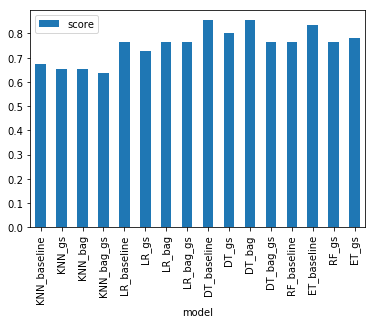

In [100]:
bar_df.plot(kind='bar')

DecisionTree baseline and bagged are at the top, with ExtraTrees baseline close behind

In [114]:
from sklearn.cross_validation import cross_val_score, StratifiedKFold
strat = []
for i in [[KNeighborsClassifier(),'KNN_baseline'],
 [gridsearch_knn.best_estimator_,'KNN_gs'],
 [BaggingClassifier(KNeighborsClassifier()),'KNN_bag'],
 [LogisticRegression(),'LR_baseline'],
 [gridsearch_LR.best_estimator_,'LR_gs'],
 [BaggingClassifier(LogisticRegression()),'LR_bag'],
 [DecisionTreeClassifier(),'DT_baseline'],
 [gridsearch_dt.best_estimator_,'DT_gs'],
 [BaggingClassifier(gridsearch_dt.best_estimator_),'DT_bag'],
 [RandomForestClassifier(),'RF_baseline'],
 [ExtraTreesClassifier(),'ET_baseline'],
 [RandomForestClassifier(class_weight=None,criterion='gini',max_depth= 3,min_samples_split= 2,n_estimators=50),'RF_gs'],
 [ExtraTreesClassifier(class_weight=None,criterion='gini',max_depth= 3,min_samples_split= 2,n_estimators=3),'ET_gs']
]:
    
    strat.append([i[1], cross_val_score(i[0], X, y,cv=StratifiedKFold(y, shuffle=True),n_jobs=-1).mean()])

In [116]:
for i in [[KNeighborsClassifier(),'KNN_bag_gs'],
[LogisticRegression(C=1,penalty='l2'),'LR_bag_gs'],
[gridsearch_dt.best_estimator_,'DT_bag_gs']
]:
    

    bagging_params = {'n_estimators': [10, 20],
                      'max_samples': [0.7, 1.0],
                      'max_features': [0.7, 1.0],
                      'bootstrap_features': [True, False]}
    bag = GridSearchCV(BaggingClassifier(i[0]),
                                bagging_params, n_jobs=-1,
                                cv=5)

    
    bag.fit(X_train, y_train)

    strat.append([i[1], cross_val_score(bag.best_estimator_, X, y,cv=StratifiedKFold(y, shuffle=True),n_jobs=-1).mean()])

# entry['model'] = name
# entry['score'] = bag.best_score_

# all_models.append(entry)
# #     evaluate_model(bag.best_estimator_,name)
# #     return bag.best_estimator

In [117]:
strat

[['KNN_baseline', 0.67759562841530052],
 ['KNN_gs', 0.68852459016393441],
 ['KNN_bag', 0.60109289617486339],
 ['LR_baseline', 0.74863387978142082],
 ['LR_gs', 0.76502732240437155],
 ['LR_bag', 0.76502732240437155],
 ['DT_baseline', 0.78142076502732249],
 ['DT_gs', 0.73770491803278693],
 ['DT_bag', 0.78142076502732249],
 ['RF_baseline', 0.74863387978142082],
 ['ET_baseline', 0.75956284153005471],
 ['RF_gs', 0.75409836065573765],
 ['ET_gs', 0.72677595628415304],
 ['KNN_bag_gs', 0.72131147540983598],
 ['LR_bag_gs', 0.77595628415300544],
 ['DT_bag_gs', 0.68852459016393441]]

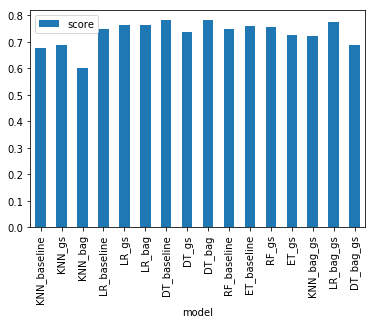

In [118]:


bar_df = pd.DataFrame(strat,columns=['model','score'])
bar_df.set_index('model',inplace=True)
bar_df.plot(kind='bar')

Looks like LR with bagging and gridsearch jumped up close to the top performing DT models. In general, it looks like nearly all models performed better.

## Bonus

We have encoded the data using a map that preserves the scale.
Would our results have changed if we had encoded the categorical data using `pd.get_dummies` or `OneHotEncoder`  to encode them as binary variables instead?

1. Repeat the analysis for this scenario. Is it better?
- Experiment with other models or other parameters, can you beat your classmates' best score?